In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 0
USE_SAMPLE = SAMPLE_LEVEL == 1
USE_TOY_SAMPLE = SAMPLE_LEVEL == 2

FORCE_REWRITE = True#(ON_KAGGLE and SAMPLE_LEVEL == 0)

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
# THIS CELL WILL BE REMOVE WITH SCRIPTS IN SRC
if './src/' not in sys.path:
    sys.path.append('./src/')

from preprocessing import *
from metrics import *
from cv import *
from modeling import *
from tracking import track_experiment
import util

In [7]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'
ASSET_DETAILS_PATH = RAW_DIR / 'asset_details.csv'

In [8]:
if USE_TOY_SAMPLE:
    print('USING TOY DATASET')
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    print('USING SAMPLE DATASET')
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    print('USING RAW DATASET')
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

USING RAW DATASET


In [9]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [10]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 18.8 s, sys: 1.87 s, total: 20.7 s
Wall time: 23.1 s


In [11]:
raw_df = ingest_data(raw_df, asset_details_path=ASSET_DETAILS_PATH)

In [12]:
raw_df.sort_values(by=['Asset_ID', 'date'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [13]:
raw_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,date
0,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,Binance Coin,2018-01-01 00:01:00
1,1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,Binance Coin,2018-01-01 00:02:00
2,1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501393,-0.015410,Binance Coin,2018-01-01 00:03:00
3,1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,Binance Coin,2018-01-01 00:04:00
4,1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,Binance Coin,2018-01-01 00:05:00


In [14]:
TARGET = 'Target'
INDEX_COLS = ['Asset_ID', 'Asset_Name', 'date', 'timestamp']

In [15]:
RAW_FEATURES = ['Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP']

In [16]:
for feature in RAW_FEATURES:
    fmin = raw_df.groupby('Asset_ID')[feature].min()
    fmax = raw_df.groupby('Asset_ID')[feature].max()
    
    broadcasted_fmin = raw_df['Asset_ID'].map(fmin)
    broadcasted_fmax = raw_df['Asset_ID'].map(fmax)
    
    raw_df[feature] = (raw_df[feature] - broadcasted_fmin) / (broadcasted_fmax - broadcasted_fmin)

In [17]:
feature_data = compute_features(raw_df)

In [18]:
feature_data = feature_data.dropna(subset=[TARGET]).reset_index(drop=True)

In [19]:
feature_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,date,upper_shadow,lower_shador
0,1514764860,0,0.000125,0.006409,0.006385,0.006434,0.006415,0.000369,0.006412,-0.014399,Binance Coin,2018-01-01 00:01:00,-0.000031,-0.000025
1,1514764920,0,0.000187,0.006409,0.006385,0.006412,0.006393,0.000336,0.006398,-0.015875,Binance Coin,2018-01-01 00:02:00,-0.000025,-0.000019
2,1514764980,0,0.001373,0.006375,0.006384,0.006368,0.006350,0.007283,0.006370,-0.015410,Binance Coin,2018-01-01 00:03:00,0.000009,-0.000019
3,1514765040,0,0.000406,0.006367,0.006351,0.006353,0.006373,0.000592,0.006339,-0.012524,Binance Coin,2018-01-01 00:04:00,-0.000022,0.000013
4,1514765100,0,0.000125,0.006366,0.006342,0.006326,0.006308,0.000589,0.006308,-0.005940,Binance Coin,2018-01-01 00:05:00,-0.000025,-0.000019


In [20]:
feature_data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,date,upper_shadow,lower_shador
23486463,1632181200,13,0.031926,0.485383,0.485087,0.487113,0.485511,0.016266,0.485645,0.000199,TRON,2021-09-20 23:40:00,-0.000424,-0.001729
23486464,1632181260,13,0.023142,0.486110,0.486378,0.488679,0.487027,0.005642,0.487345,-0.003477,TRON,2021-09-20 23:41:00,-0.000649,-0.002569
23486465,1632181320,13,0.017049,0.487038,0.486483,0.489328,0.486891,0.006768,0.487697,-0.002437,TRON,2021-09-20 23:42:00,-0.000556,-0.002437
23486466,1632181380,13,0.014974,0.487244,0.486454,0.488957,0.486320,0.004450,0.487382,0.004843,TRON,2021-09-20 23:43:00,-0.000790,-0.002637
23486467,1632181440,13,0.016562,0.485985,0.485545,0.487814,0.485188,0.005392,0.486292,0.004163,TRON,2021-09-20 23:44:00,-0.000440,-0.002626


In [21]:
PULIC_LB_RANGE = ['2021-06-13 00:00:00',
                  '2021-09-13 00:00:00'] # 3 MONTH WORTH OF DATA

if USE_TOY_SAMPLE:
    EVAL_PERIODS = [['2021-09-15', '2021-09-22']]

elif USE_SAMPLE:
    EVAL_PERIODS = [PULIC_LB_RANGE]
    
else:
    EVAL_PERIODS = [['2019-01-01', '2019-04-01'],
                    ['2021-03-13', '2021-06-12 00:00:00'], 
                    PULIC_LB_RANGE]
    
CV_PARAMS = {'gap_unit': 'min'}

In [22]:
# FEATURE TO TRAIN
COLUMNS_TO_DROP = [TARGET, 'Asset_Name', 'date', 'timestamp']
FEATURES = feature_data.columns.drop(COLUMNS_TO_DROP)

# OUTPUT DIR
OUTPUT_PATH = Path('artifacts/baseline/')
if SAMPLE_LEVEL > 0:
    OUTPUT_PATH = OUTPUT_PATH / f'sample/{SAMPLE_LEVEL}'
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)
OUTPUT_MODEL_PATH = OUTPUT_PATH / 'xgb.pkl'


In [23]:
model_params = util.load_config('conf/model/xgboost/base.yml')
config = {'model': model_params, 'output_dir': str(OUTPUT_MODEL_PATH)}

In [24]:
### make transformer

In [25]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

In [26]:
from sklearn.preprocessing import FunctionTransformer

In [27]:
filter_pipeline = FunctionTransformer(lambda d: d[FEATURES])

In [28]:


def train_model(config, train_data: pd.DataFrame, valid_data: pd.DataFrame=None, pipeline=None):
    weight = train_data['Asset_Name'].map(ASSET_WEIGHT) / TOTAL_WEIGHT_SUM
    model = Pipeline([('filter', filter_pipeline),
                      ('model', XGBRegressor(**config['model']))])
    model.fit(train_data, train_data[TARGET], model__sample_weight=weight)    
    return model

In [29]:
def filter_by_index(df: pd.DataFrame, index) -> pd.DataFrame:
    return df.loc[index, :].reset_index(drop=True)

In [30]:
CV = TimeSeriesSplit(EVAL_PERIODS, **CV_PARAMS)
evaluator = Evaluator(cv=CV, score_fn=compute_metrics)
eval_output = evaluator.run(train_model, config, feature_data)

fold=0
theor_corr       0.007992
weighted_corr    0.010565
corr_min        -0.036289
corr_max         0.051912
corr_std         0.021684
dtype: float64
fold=1
theor_corr       0.000046
weighted_corr    0.003566
corr_min        -0.010718
corr_max         0.041849
corr_std         0.015442
dtype: float64
fold=2
theor_corr       0.005597
weighted_corr    0.003602
corr_min        -0.011812
corr_max         0.054196
corr_std         0.017177
dtype: float64


In [31]:
scores = pd.DataFrame([fold['scores'] for fold in eval_output])
scores['eval_period'] = EVAL_PERIODS

In [32]:
scores

,theor_corr,weighted_corr,corr_min,corr_max,corr_std,eval_period
0,0.007992,0.010565,-0.036289,0.051912,0.021684,"[2019-01-01, 2019-04-01]"
1,0.000046,0.003566,-0.010718,0.041849,0.015442,"[2021-03-13, 2021-06-12 00:00:00]"
2,0.005597,0.003602,-0.011812,0.054196,0.017177,"[2021-06-13 00:00:00, 2021-09-13 00:00:00]"


In [33]:
valid_corrs = pd.concat([fold['corrs'].assign(fold=e) for e, fold in enumerate(eval_output)])
valid_corrs['eval_period'] = valid_corrs['fold'].map(lambda d: EVAL_PERIODS[d])

In [34]:
valid_corrs

,Asset_Name,corr,weight,weighted_corr,fold,eval_period
0,Binance Coin,0.017010,4.304065,0.073212,0,"[2019-01-01, 2019-04-01]"
1,Bitcoin,0.007999,6.779922,0.054229,0,"[2019-01-01, 2019-04-01]"
2,Bitcoin Cash,-0.003195,2.397895,-0.007662,0,"[2019-01-01, 2019-04-01]"
3,Cardano,-0.005300,4.406719,-0.023357,0,"[2019-01-01, 2019-04-01]"
4,EOS.IO,0.008455,1.386294,0.011721,0,"[2019-01-01, 2019-04-01]"
5,Ethereum,0.029423,5.894403,0.173431,0,"[2019-01-01, 2019-04-01]"
6,Ethereum Classic,0.015086,2.079442,0.031371,0,"[2019-01-01, 2019-04-01]"
7,IOTA,-0.001871,1.098612,-0.002055,0,"[2019-01-01, 2019-04-01]"
8,Litecoin,-0.008715,2.397895,-0.020899,0,"[2019-01-01, 2019-04-01]"
9,Maker,-0.036289,1.098612,-0.039868,0,"[2019-01-01, 2019-04-01]"


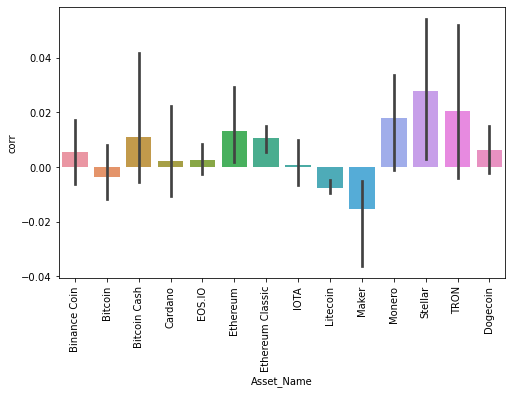

In [35]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Asset_Name', y='corr', data=valid_corrs)
plt.xticks(rotation=90);

In [37]:
if SAMPLE_LEVEL == 0:
    scores_mean = scores.mean().to_dict()
    valid_corrs.to_csv(OUTPUT_PATH / 'corrs.csv', index=False)
    
    scores.to_csv(OUTPUT_PATH / 'cv_scores.csv', index=False)
    track_experiment('metric-weight-single-model', mlflow_experiment='leaderboard',
                     config=config,
                     scores=scores_mean, artifacts_dir=str(OUTPUT_PATH))